In [1]:
import keras
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Flatten, Activation, Reshape, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import l2
from keras.layers.merge import add
from keras.engine.topology import Layer
from keras.engine import InputSpec


import numpy as np
import scipy.misc as misc
import os
import glob
from random import shuffle, randint

import matplotlib.pyplot as plt

/home/mirlab/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def resize_images(x, size, method='bilinear'):
    new_size = tf.convert_to_tensor(size, dtype=tf.int32)
    resized = tf.image.resize_images(x, new_size)
    return resized

In [3]:
class BilinearUpSampling2D(Layer):
    """Upsampling2D with bilinear interpolation."""

    def __init__(self, target_shape=None, data_format=None, **kwargs):
        if data_format is None:
            data_format = K.image_data_format()
        assert data_format in {
            'channels_last', 'channels_first'}
        self.data_format = data_format
        self.input_spec = [InputSpec(ndim=4)]
        self.target_shape = target_shape
        if self.data_format == 'channels_first':
            self.target_size = (target_shape[2], target_shape[3])
        elif self.data_format == 'channels_last':
            self.target_size = (target_shape[1], target_shape[2])
        super(BilinearUpSampling2D, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            return (input_shape[0], self.target_size[0],
                    self.target_size[1], input_shape[3])
        else:
            return (input_shape[0], input_shape[1],
                    self.target_size[0], self.target_size[1])

    def call(self, inputs):
        return resize_images(inputs, size=self.target_size,
                             method='bilinear')

    def get_config(self):
        config = {'target_shape': self.target_shape,
                'data_format': self.data_format}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class CroppingLike2D(Layer):
    def __init__(self, target_shape, offset=None, data_format=None,
                 **kwargs):
        """Crop to target.
        If only one `offset` is set, then all dimensions are offset by this amount.
        """
        super(CroppingLike2D, self).__init__(**kwargs)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.target_shape = target_shape
        if offset is None or offset == 'centered':
            self.offset = 'centered'
        elif isinstance(offset, int):
            self.offset = (offset, offset)
        elif hasattr(offset, '__len__'):
            if len(offset) != 2:
                raise ValueError('`offset` should have two elements. '
                                 'Found: ' + str(offset))
            self.offset = offset
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            return (input_shape[0],
                    input_shape[1],
                    self.target_shape[2],
                    self.target_shape[3])
        else:
            return (input_shape[0],
                    self.target_shape[1],
                    self.target_shape[2],
                    input_shape[3])

    def call(self, inputs):
        input_shape = K.int_shape(inputs)
        if self.data_format == 'channels_first':
            input_height = input_shape[2]
            input_width = input_shape[3]
            target_height = self.target_shape[2]
            target_width = self.target_shape[3]
            if target_height > input_height or target_width > input_width:
                raise ValueError('The Tensor to be cropped need to be smaller'
                                 'or equal to the target Tensor.')

            if self.offset == 'centered':
                self.offset = [int((input_height - target_height) / 2),
                               int((input_width - target_width) / 2)]

            if self.offset[0] + target_height > input_height:
                raise ValueError('Height index out of range: '
                                 + str(self.offset[0] + target_height))
            if self.offset[1] + target_width > input_width:
                raise ValueError('Width index out of range:'
                                 + str(self.offset[1] + target_width))

            return inputs[:,
                          :,
                          self.offset[0]:self.offset[0] + target_height,
                          self.offset[1]:self.offset[1] + target_width]
        elif self.data_format == 'channels_last':
            input_height = input_shape[1]
            input_width = input_shape[2]
            target_height = self.target_shape[1]
            target_width = self.target_shape[2]
            if target_height > input_height or target_width > input_width:
                raise ValueError('The Tensor to be cropped need to be smaller'
                                 'or equal to the target Tensor.')

            if self.offset == 'centered':
                self.offset = [int((input_height - target_height) / 2),
                               int((input_width - target_width) / 2)]

            if self.offset[0] + target_height > input_height:
                raise ValueError('Height index out of range: '
                                 + str(self.offset[0] + target_height))
            if self.offset[1] + target_width > input_width:
                raise ValueError('Width index out of range:'
                                 + str(self.offset[1] + target_width))
            output = inputs[:,
                            self.offset[0]:self.offset[0] + target_height,
                            self.offset[1]:self.offset[1] + target_width,
                            :]
            return output

    def get_config(self):
        config = {'target_shape': self.target_shape,
                  'offset': self.offset,
                  'data_format': self.data_format}
        base_config = super(CroppingLike2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
def vgg_conv(filters, convs, padding=False, weight_decay=0.,
             block_name='blockx'):
    def f(x):
        for i in range(convs):
            if block_name == 'block1' and i == 0:
                if padding is True:
                    x = ZeroPadding2D(padding=(100, 100))(x)
                x = Conv2D(filters, (3,3), activation='relu', padding='same',
                           kernel_initializer='he_normal',
                           kernel_regularizer=l2(weight_decay),
                           name='{}_conv{}'.format(block_name, int(i+1)))(x)
            else:
                x = Conv2D(filters, (3,3), activation='relu', padding='same',
                           kernel_initializer='he_normal',
                           kernel_regularizer=l2(weight_decay),
                           name='{}_conv{}'.format(block_name, int(i+1)))(x)
        pool = MaxPooling2D((2,2), strides=(2,2), padding='same',
                            name='{}_pool'.format(block_name))(x)
        return pool
    return f

def vgg_fc(filters, weight_decay=0., block_name='block5'):
    def f(x):
        fc6 = Conv2D(filters=4096, kernel_size=(3, 3),
                     activation='relu', padding='same',
                     dilation_rate=(2, 2),
                     kernel_initializer='he_normal',
                     kernel_regularizer=l2(weight_decay),
                     name='{}_fc6'.format(block_name))(x)
        drop6 = Dropout(0.5)(fc6)
        return drop6
    return f

def vgg_deconv(classes, scale=1, kernel_size=(4, 4), strides=(2, 2),
               crop_offset='centered', weight_decay=0., block_name='featx'):
    def f(x, y):
        def scaling(xx, ss=1):
            return xx * ss
        scaled = Lambda(scaling, arguments={'ss': scale},
                        name='scale_{}'.format(block_name))(x)
        score = Conv2D(filters=classes, kernel_size=(1, 1),
                       activation='linear',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(weight_decay),
                       name='score_{}'.format(block_name))(scaled)
        if y is None:
            upscore = Conv2DTranspose(filters=classes, kernel_size=kernel_size,
                                      strides=strides, padding='valid',
                                      kernel_initializer='he_normal',
                                      kernel_regularizer=l2(weight_decay),
                                      use_bias=False,
                                      name='upscore_{}'.format(block_name))(score)
        else:
            crop = CroppingLike2D(target_shape=K.int_shape(y),
                                  offset=crop_offset,
                                  name='crop_{}'.format(block_name))(score)
            merge = add([y, crop])
            upscore = Conv2DTranspose(filters=classes, kernel_size=kernel_size,
                                      strides=strides, padding='valid',
                                      kernel_initializer='he_normal',
                                      kernel_regularizer=l2(weight_decay),
                                      use_bias=False,
                                      name='upscore_{}'.format(block_name))(merge)
        return upscore
    return f

def vgg_upsampling(classes, target_shape=None, scale=1, weight_decay=0., block_name='featx'):
    def f(x, y):
        score = Conv2D(filters=classes, kernel_size=(1, 1),
                       activation='linear',
                       padding='valid',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(weight_decay),
                       name='score_{}'.format(block_name))(x)
        if y is not None:
            def scaling(xx, ss=1):
                return xx * ss
            scaled = Lambda(scaling, arguments={'ss': scale},
                            name='scale_{}'.format(block_name))(score)
            score = add([y, scaled])
        upscore = BilinearUpSampling2D(
            target_shape=target_shape,
            name='upscore_{}'.format(block_name))(score)
        return upscore
    return f

def vgg_score(crop_offset='centered'):
    def f(x, y):
        score = CroppingLike2D(target_shape=K.int_shape(
            x), offset=crop_offset, name='score')(y)
        return score
    return f

# Encoder

In [5]:
class Encoder(Model):
    def __init__(self, inputs, blocks, 
                 weights=None, trainable=True,
                 name='encoder'):
        inverse_pyramid = []
        
        conv_blocks = blocks[:-1]
        for i, block in enumerate(conv_blocks):
            if i == 0:
                x = block(inputs)
                inverse_pyramid.append(x)
            elif i < len(conv_blocks) - 1:
                x = block(x)
                inverse_pyramid.append(x)
            else:
                x = block(x)
        
        # fully convolutional block
        fc_block = blocks[-1]
        y = fc_block(x)
        inverse_pyramid.append(y)
        
        # Reverse the pyramid features
        outputs = list(reversed(inverse_pyramid))
        
        self.inputs = inputs
        self.outputs = outputs

# Decoder

In [6]:
def Decoder(pyramid, blocks):
    if len(blocks) != len(pyramid):
        raise ValueError('`blocks` needs to match the length of'
                         '`pyramid`.')
    
    decoded = None
    for feat, blk in zip(pyramid, blocks):
        decoded = blk(feat, decoded)
    return decoded

# FCN

In [7]:
inputs = Input(shape=(250, 250, 1))

In [8]:
blocks = [vgg_conv(64, 1, block_name='block1'),
          vgg_conv(128, 1, block_name='block2'),
          vgg_conv(256, 1, block_name='block3'),
          vgg_conv(512, 1, block_name='block4'),
          vgg_conv(512, 1, block_name='block5'),
          vgg_fc(4096)]

In [9]:
encoder = Encoder(inputs, blocks)

In [10]:
feat_pyramid = encoder.outputs   # A feature pyramid with 5 scales
feat_pyramid = feat_pyramid[:4]  # Select only the top three scale of the pyramid
feat_pyramid.append(inputs)      # Add image to the bottom of the pyramid

In [11]:
decode_blocks = [
vgg_upsampling(classes=124, target_shape=(None, 16, 16, None), scale=1, block_name='feat1'),            
vgg_upsampling(classes=124, target_shape=(None, 32, 32, None),  scale=0.01, block_name='feat2'),
vgg_upsampling(classes=124, target_shape=(None, 63, 63, None),  scale=0.0001, block_name='feat3'),
vgg_upsampling(classes=124, target_shape=(None, 250, 250, None),  scale=0.0001, block_name='feat4'),
]

outputs = Decoder(pyramid=feat_pyramid[:-1], blocks=decode_blocks)

In [12]:
outputs = Activation('softmax')(outputs)

In [13]:
model = Model(inputs=inputs, outputs=outputs)

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training 

## Load data

In [16]:
class seg_dataset_reader:
    path = ""
    class_mappings = ""
    files = []
    images = []
    annotations = []
    test_images = []
    test_annotations = []
    batch_offset = 0
    epochs_completed = 0

    def __init__(self, deepscores_path, max_pages=40, crop=True, crop_size=[1000,1000], test_size=20):
        """
        Initialize a file reader for the DeepScores classification data
        :param records_list: path to the dataset
        sample record: {'image': f, 'annotation': annotation_file, 'filename': filename}
        """
        print("Initializing DeepScores Classification Batch Dataset Reader...")
        self.path = deepscores_path
        self.max_pages = max_pages
        self.crop = crop
        self.crop_size = crop_size
        self.test_size = test_size

        images_list = []
        images_glob = os.path.join(self.path, "images_png", '*.' + 'png')
        images_list.extend(glob.glob(images_glob))

        #shuffle image list
        shuffle(images_list)

        if max_pages is None:
            max_pages = len(images_list)
            import sys
            sys.exit(1)

        if max_pages > len(images_list):
            print("Not enough data, only " + str(len(images_list)) + " available")

        if test_size >= max_pages:
            print("Test set too big ("+str(test_size)+"), max_pages is: "+str(max_pages))
            import sys
            sys.exit(1)

        print("Splitting dataset, train: "+str(max_pages-test_size)+" images, test: "+str(test_size)+ " images")
        test_image_list = images_list[0:test_size]
        train_image_list = images_list[test_size:max_pages]

        # test_annotation_list = [image_file.replace("/images_png/", "/pix_annotations_png/") for image_file in test_image_list]
        # train_annotation_list = [image_file.replace("/images_png/", "/pix_annotations_png/") for image_file in train_image_list]

        self._read_images(test_image_list,train_image_list)

    def _read_images(self,test_image_list,train_image_list):

        dat_train = [self._transform(filename) for filename in train_image_list]
        for dat in dat_train:
            self.images.append(dat[0])
            self.annotations.append(dat[1])
        self.images = np.array(self.images)
        self.images = np.expand_dims(self.images, -1)

        self.annotations = np.array(self.annotations)
        self.annotations = np.expand_dims(self.annotations, -1)

        print("Training set done")
        dat_test = [self._transform(filename) for filename in test_image_list]
        for dat in dat_test:
            self.test_images.append(dat[0])
            self.test_annotations.append(dat[1])
        self.test_images = np.array(self.test_images)
        self.test_images = np.expand_dims(self.test_images, -1)

        self.test_annotations = np.array(self.test_annotations)
        self.test_annotations = np.expand_dims(self.test_annotations, -1)
        print("Test set done")


    def _transform(self, filename):
        image = misc.imread(filename)
        annotation = misc.imread(filename.replace("/images_png/", "/pix_annotations_png/"))
        print("im working!" + str(randint(0,10)))
        if not image.shape[0:2] == annotation.shape[0:2]:
            print("input and annotation have different sizes!")
            import sys
            import pdb
            pdb.set_trace()
            sys.exit(1)

        if image.shape[-1] != 1:
            # take mean over color channels, image BW anyways --> fix in dataset creation
            image = np.mean(image, -1)

        if self.crop:
            coord_0 = randint(0, (image.shape[0] - self.crop_size[0]))
            coord_1 = randint(0, (image.shape[1] - self.crop_size[1]))

            image = image[coord_0:(coord_0+self.crop_size[0]),coord_1:(coord_1+self.crop_size[1])]
            annotation = annotation[coord_0:(coord_0 + self.crop_size[0]), coord_1:(coord_1 + self.crop_size[1])]

        return [image, annotation]

    # from PIL import Image
    # im = Image.fromarray(image)
    # im.show()
    # im = Image.fromarray(annotation)
    # im.show()


    def get_records(self):
        return self.images, self.annotations

    def reset_batch_offset(self, offset=0):
        self.batch_offset = offset

    def get_test_records(self):
        return self.test_images, self.test_annotations

    def next_batch(self, batch_size):
        start = self.batch_offset
        self.batch_offset += batch_size
        if self.batch_offset > self.images.shape[0]:
            # Finished epoch
            self.epochs_completed += 1
            print("****************** Epochs completed: " + str(self.epochs_completed) + "******************")
            # Shuffle the data
            perm = np.arange(self.images.shape[0])
            np.random.shuffle(perm)
            self.images = self.images[perm]
            self.annotations = self.annotations[perm]
            # Start next epoch
            start = 0
            self.batch_offset = batch_size

        end = self.batch_offset
        return self.images[start:end], self.annotations[start:end]

    def get_random_batch(self, batch_size):
        indexes = np.random.randint(0, self.images.shape[0], size=[batch_size]).tolist()
        return self.images[indexes], self.annotations[indexes]

In [17]:
data_reader = seg_dataset_reader('/home/mirlab/Downloads/DeepScores/',
                                 crop=True, crop_size=[250,250])

Initializing DeepScores Classification Batch Dataset Reader...
Splitting dataset, train: 20 images, test: 20 images


/home/mirlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/mirlab/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


im working!3
im working!6
im working!6
im working!2
im working!6
im working!9
im working!6
im working!5
im working!0
im working!1
im working!1
im working!7
im working!4
im working!4
im working!10
im working!9
im working!0
im working!2
im working!1
im working!7
Training set done
im working!0
im working!5
im working!3
im working!5
im working!0
im working!3
im working!5
im working!10
im working!6
im working!10
im working!2
im working!10
im working!4
im working!8
im working!6
im working!6
im working!4
im working!1
im working!3
im working!7
Test set done


In [18]:
train_img, train_annotation = data_reader.next_batch(1)

In [19]:
model.fit(x=train_img, y=train_annotation)

Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 16.1181 - acc: 0.0000e+00


# Test model

In [20]:
prediction = np.argmax(model.predict(train_img), axis=-1) # get the argmax of 124 classes

Text(0.5,1,'Semantic Prediction')

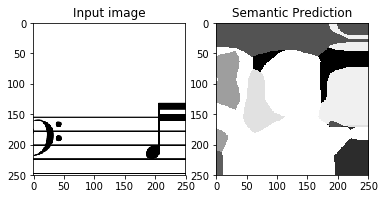

In [21]:
plt.subplot(1,2,1)
plt.imshow(train_img[0,:,:,0], cmap='gray')
plt.title("Input image")
plt.subplot(1,2,2)
plt.imshow(prediction[0,:,:], cmap='gray')
plt.title("Semantic Prediction")